# Reads and preprocesses dataset
1. Read UNSW dataset
2. Delete rows with NaNs
3. Remove (IP src/dst, Port src/dst) columns
4. Remove duplicated columns
5. Map categorical columns --> one-hot encoded columns


In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import History
import shap
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


LOAD_MODELS = True
THRESHOLD = 0.5

df = pd.read_csv("NF-UNSW-NB15-v2.csv")
df = df.dropna()

connection_specific_cols = ["IPV4_SRC_ADDR", "L4_SRC_PORT", "L4_DST_PORT", "IPV4_DST_ADDR", "DNS_QUERY_ID"]
duplicated_cols = ["Attack", "ICMP_IPV4_TYPE"]

df = df.drop(connection_specific_cols, axis=1)
df = df.drop(duplicated_cols, axis=1)

## Sample dataset equally from benign and malicious packets
This is a technique to handle "unbalanced" datasets (https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/).

Problem: very low count of malicious packets. Models that predict that every packet benign appear to have very low error.\
Solution: feed equal counts of malicious and benign packets to models.

In [3]:
from sklearn.utils import shuffle

#Only get 20,000 of each type
SIZE = 20000

df = shuffle(df)
benign = df[df["Label"] == 0][:SIZE]
attacks = df[df["Label"] == 1][:SIZE]

full_df = shuffle(benign.append(attacks))

categorical_columns = ["PROTOCOL", 
                       "L7_PROTO", 
                       "TCP_FLAGS", 
                       "SERVER_TCP_FLAGS", 
                       "CLIENT_TCP_FLAGS", 
                       "FTP_COMMAND_RET_CODE",
                       "DNS_QUERY_TYPE",
                       "ICMP_TYPE"]

dropped_cat_df = full_df.drop(categorical_columns, axis=1)

## Model Definition

Model: ML model

DataFrame: input 

SavePath: path to storing info

In [51]:
logistic_regression = {
    "Model": Sequential([Dense(1, activation='sigmoid')]),
    "DataFrame": dropped_cat_df,
    "SavePath": "Log"
}

mlp_regression = {
    "Model": Sequential([
                Dense(20, activation='relu'),
                Dense(20, activation='relu'),
                Dense(20, activation='relu'),
                Dense(20, activation='relu'),
                Dense(1, activation='sigmoid')
            ]),
    "DataFrame": full_df,
    "SavePath": "MLP"
}

## Create machine-learning input
Input columns: all original and one-hot encoded columns\
Output column: 0 or 1 . Where 0 denotes a benign packet, 1 denotes a malicious packet.

In [4]:
import numpy as np
from sklearn import preprocessing

def get_input_output(frame):
    x = np.asarray(frame.loc[:, frame.columns != "Label"])
    y = np.asarray(frame.loc[:, "Label"])

    x_normalized = preprocessing.normalize(x, norm='l2')
    return x_normalized, y

## Model Training Code

Most important aspects:\
Model compilation,\
Generating binary outcomes from models

In [57]:
def model_runner(model_info, load):
    
    path = model_info["SavePath"]

    # generates input (x) and output (y)
    x, y = get_input_output(model_info["DataFrame"])

    # model compilation setup
    history = History()
    callback = EarlyStopping(monitor='val_loss', patience=25)
    optimizer = SGD(learning_rate=0.1)
    
    model = model_info["Model"]
    model.compile(optimizer=optimizer, loss='mse')

    if load:
        #load weights from path
        model.load_weights(f"{path}/Model")
        history_dict = pd.read_csv(f"{path}/history.csv").to_dict()

    else:
        model.fit(x, y, epochs=1000, validation_split=0.2, callbacks=[callback, history], verbose=0)
        model.save_weights(f"{path}/Model")
        error_df = pd.DataFrame.from_dict(history.history)
        error_df.to_csv(f"{path}/history.csv", index=False)
        
        history_dict = history.history

    # print training and validation loss
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    min_epoch = val_loss.index(min(val_loss))
    print(f"Training Loss = {loss[min_epoch]}")
    print(f"Validation Loss = {val_loss[min_epoch]}")

    sns.lineplot(data=history_dict)
    
    #Turns probability output to binary 
    #e.g. 0.6787 --> 1
    #e.g. 0.0135 --> 0 
    # Important for generating # incorrect vs. # of correct guesses 
    binary_outcomes = THRESHOLD < model.predict(x)
    
    # plots confusion matrix
    confusion = confusion_matrix(binary_outcomes, y[:, None])
    confusion_display = ConfusionMatrixDisplay(confusion)
    confusion_display.plot()

## Test Logistic Regression model

Training Loss = 0.19783546030521393
Validation Loss = 0.1961313933134079


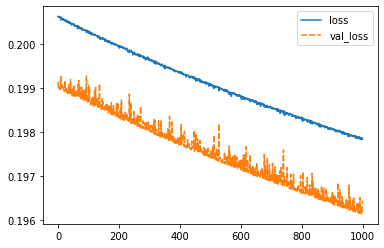

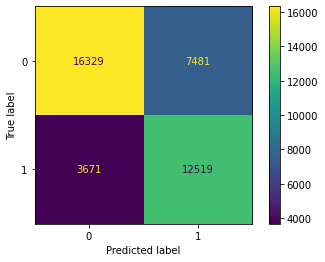

In [56]:
model_runner(logistic_regression, False)

## Shapley values for 15 predictions using Logistic Regression

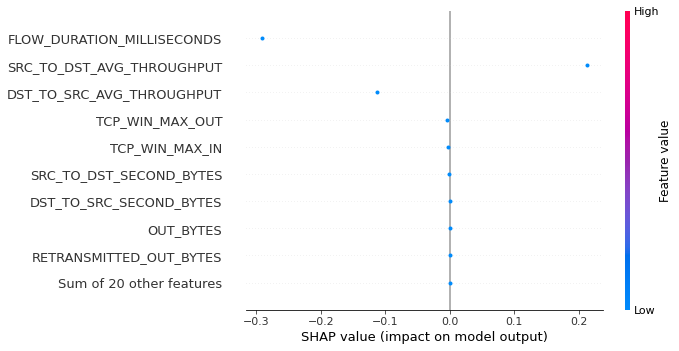

In [14]:
import shap

explainer = shap.Explainer(log_reg, x[:5000], feature_names=dropped_cat_df.columns)
shap_values = explainer(x[:1])    
shap.plots.beeswarm(shap_values)

## Test MLP (Feed-forward Neural Network) model

Epoch 1/1000
1000/1000 [==============================] - 1s 718us/step - loss: 0.2119 - val_loss: 0.1983
Epoch 2/1000
1000/1000 [==============================] - 1s 652us/step - loss: 0.2002 - val_loss: 0.1974
Epoch 3/1000
1000/1000 [==============================] - 1s 654us/step - loss: 0.1997 - val_loss: 0.1966
Epoch 4/1000
1000/1000 [==============================] - 1s 657us/step - loss: 0.1992 - val_loss: 0.1959
Epoch 5/1000
1000/1000 [==============================] - 1s 651us/step - loss: 0.1984 - val_loss: 0.1958
Epoch 6/1000
1000/1000 [==============================] - 1s 676us/step - loss: 0.1978 - val_loss: 0.1970
Epoch 7/1000
1000/1000 [==============================] - 1s 658us/step - loss: 0.1970 - val_loss: 0.1945
Epoch 8/1000
1000/1000 [==============================] - 1s 663us/step - loss: 0.1959 - val_loss: 0.1921
Epoch 9/1000
1000/1000 [==============================] - 1s 668us/step - loss: 0.1940 - val_loss: 0.1943
Epoch 10/1000
1000/1000 [=====================

1000/1000 [==============================] - 1s 705us/step - loss: 0.1267 - val_loss: 0.1166
Epoch 78/1000
1000/1000 [==============================] - 1s 687us/step - loss: 0.1263 - val_loss: 0.1131
Epoch 79/1000
1000/1000 [==============================] - 1s 682us/step - loss: 0.1257 - val_loss: 0.1163
Epoch 80/1000
1000/1000 [==============================] - 1s 705us/step - loss: 0.1263 - val_loss: 0.1365
Epoch 81/1000
1000/1000 [==============================] - 1s 705us/step - loss: 0.1256 - val_loss: 0.1121
Epoch 82/1000
1000/1000 [==============================] - 1s 695us/step - loss: 0.1259 - val_loss: 0.1303
Epoch 83/1000
1000/1000 [==============================] - 1s 703us/step - loss: 0.1256 - val_loss: 0.1191
Epoch 84/1000
1000/1000 [==============================] - 1s 718us/step - loss: 0.1248 - val_loss: 0.1183
Epoch 85/1000
1000/1000 [==============================] - 1s 685us/step - loss: 0.1238 - val_loss: 0.1143
Epoch 86/1000
1000/1000 [==========================

1000/1000 [==============================] - 1s 716us/step - loss: 0.1180 - val_loss: 0.1095
Epoch 154/1000
1000/1000 [==============================] - 1s 713us/step - loss: 0.1170 - val_loss: 0.1254
Epoch 155/1000
1000/1000 [==============================] - 1s 726us/step - loss: 0.1182 - val_loss: 0.1311
Epoch 156/1000
1000/1000 [==============================] - 1s 712us/step - loss: 0.1173 - val_loss: 0.1047
Epoch 157/1000
1000/1000 [==============================] - 1s 740us/step - loss: 0.1166 - val_loss: 0.1169
Epoch 158/1000
1000/1000 [==============================] - 1s 743us/step - loss: 0.1168 - val_loss: 0.1082
Epoch 159/1000
1000/1000 [==============================] - 1s 736us/step - loss: 0.1173 - val_loss: 0.1052
Epoch 160/1000
1000/1000 [==============================] - 1s 739us/step - loss: 0.1176 - val_loss: 0.1157
Epoch 161/1000
1000/1000 [==============================] - 1s 749us/step - loss: 0.1178 - val_loss: 0.1060
Epoch 162/1000
1000/1000 [=================

Epoch 229/1000
1000/1000 [==============================] - 1s 619us/step - loss: 0.1142 - val_loss: 0.1031
Epoch 230/1000
1000/1000 [==============================] - 1s 614us/step - loss: 0.1137 - val_loss: 0.1169
Epoch 231/1000
1000/1000 [==============================] - 1s 610us/step - loss: 0.1134 - val_loss: 0.1014
Epoch 232/1000
1000/1000 [==============================] - 1s 608us/step - loss: 0.1127 - val_loss: 0.1134
Epoch 233/1000
1000/1000 [==============================] - 1s 611us/step - loss: 0.1135 - val_loss: 0.1040
Epoch 234/1000
1000/1000 [==============================] - 1s 621us/step - loss: 0.1128 - val_loss: 0.1032
Epoch 235/1000
1000/1000 [==============================] - 1s 620us/step - loss: 0.1125 - val_loss: 0.1001
Epoch 236/1000
1000/1000 [==============================] - 1s 625us/step - loss: 0.1131 - val_loss: 0.1168
Epoch 237/1000
1000/1000 [==============================] - 1s 615us/step - loss: 0.1140 - val_loss: 0.1060
Training Loss = 0.1139883100

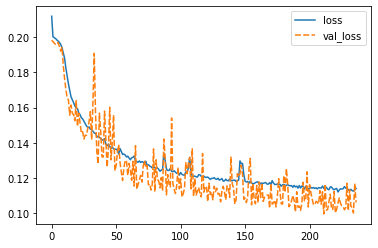

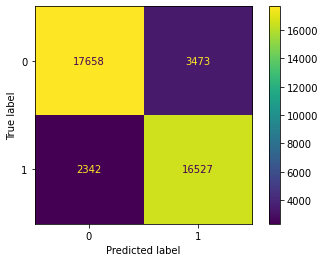

In [53]:
model_runner(mlp_regression, False)

## Shapley values for 15 predictions using MLP

<function beeswarm at 0x000001C68B4C4F70>


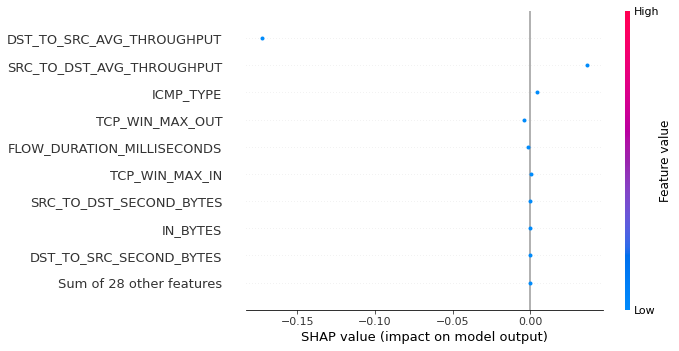

In [19]:
import shap
print(shap.plots.beeswarm)
explainer = shap.Explainer(mlp, x[:1000], feature_names=df.columns)
shap_values = explainer(x[4:5])    
shap.plots.beeswarm(shap_values)